In [7]:
%load_ext autoreload
%autoreload 2

In [35]:
import numpy as np
import open3d as o3d
import copy

from utils import *

In [36]:
xml_dir = "/home/yunzhu/Documents/project_phystouch/phystouch/data_recording/data"
xml_dir = "C:/Users/lucas/Desktop/UPC/MIT/tactile2object/intrinsics_extrinsics/data/"

cameras = ["020122061233", "821312060044", "020122061651", "821312062243"]

intrinsics = Intrinsics(xml_dir)
extrinsics = Extrinsics(xml_dir)
rgbds = RGBD(xml_dir, recording="recording_wAprilTag/20210714_003835/")
stitched_pcd = Stitching_pcds(intrinsics, extrinsics, rgbds, cameras)


# apriltag

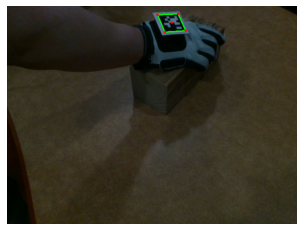

In [10]:
apriltags = AprilTags(xml_dir, intrinsics, extrinsics, recording="recording_wAprilTag/20210714_003835/", cameras=cameras)
apriltags.image(idx="000557", camera="020122061233")

In [11]:
apriltags.corners_w(idx="000557", camera="020122061233")

array([[ 0.01701285, -0.17382262,  0.47179189],
       [ 0.02835767, -0.13957428,  0.45698153],
       [ 0.06446203, -0.14574105,  0.4703773 ],
       [ 0.0531172 , -0.17998938,  0.48518765],
       [ 0.01218115, -0.16479315,  0.48897105],
       [ 0.02352598, -0.13054482,  0.47416069],
       [ 0.05963033, -0.13671158,  0.48755645],
       [ 0.04828551, -0.17095992,  0.50236681]])

# PCD
``save_view_point`` will save the view point position when closing.

In [12]:
pcd = stitched_pcd["000557"]


#save_view_point(pcd)
#load_view_point(pcd)

# PCD + AprilTags

In [13]:
# Corner pixels
corners_w = apriltags.corners_w(idx="000557", camera="020122061233")
corners_w

array([[ 0.01701285, -0.17382262,  0.47179189],
       [ 0.02835767, -0.13957428,  0.45698153],
       [ 0.06446203, -0.14574105,  0.4703773 ],
       [ 0.0531172 , -0.17998938,  0.48518765],
       [ 0.01218115, -0.16479315,  0.48897105],
       [ 0.02352598, -0.13054482,  0.47416069],
       [ 0.05963033, -0.13671158,  0.48755645],
       [ 0.04828551, -0.17095992,  0.50236681]])

In [15]:
corners_balls = get_balls_from_corners(corners_w)

vis = [pcd] + corners_balls

load_view_point(vis)

# Save PCD + AprilTag detection

In [95]:
save_dir = os.path.join(apriltags.recording_dir, "pcds")

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
for i in range(58, 600):
    idx = str(i).zfill(6)
    
    # Stiched point cloud from all the cameras
    pcd = stitched_pcd[idx]
    
    # Corner pixels
    corners_w = apriltags.corners_w(idx=idx)
    
    # If apriltag is not found visualize only the stiched point cloud
    if corners_w is None:
        vis = pcd
    
    # If the apriltag is found, visualize the corners of the apriltag
    else:        
        corners_balls = get_balls_from_corners(corners_w)
        vis = [pcd] + corners_balls
    
    filename = os.path.join(save_dir, f"img_{idx}.png")
    save_draw_geometries(vis, filename)

# Save 4 Images + AprilTag detection

In [ ]:
save_dir = os.path.join(apriltags.recording_dir, "imgs")

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
for camera in cameras:
    camera_dir = os.path.join(save_dir, camera)
    
    if not os.path.exists(camera_dir):
        os.makedirs(camera_dir)
    
    for i in range(0, 600):
        idx = str(i).zfill(6)

        img = apriltags.image(idx=idx, camera=camera, show=False)
        
        filename = os.path.join(camera_dir, f"img_{idx}.png")
        cv2.imwrite(filename, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

# Object transformation

In [39]:
obj_name = "005_tomato_soup_can"
obj_name = "003_cracker_box"
obj_name = "036_wood_block"

obj_pth = f"C:/Users/lucas/Desktop/UPC/MIT/tactile2object/estimate_object_pose/ycb_converted/{obj_name}.ply"

pcd = stitched_pcd["000000"]
transformation, obj_mesh = find_object_transformation(pcd, obj_pth)

Manual ICP
Visualization of two point clouds before manual alignment
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 

1) Please pick at least three correspondences using [shift + left click]
   Press [shift + right click] to undo point picking
2) After picking points, press 'Q' to close the window
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D INFO] Picked point #7891 (0.073, 0.022, 0.2) to add in queue.
[Open3D INFO] No point has been picked.
[Open3D INFO] No point has been picked.
[Open3D INFO] Picked point #6897 (-0.011, 0.039, 0.2) to add in queue.
[Open3D INFO] No point has been picked.
[Open3D INFO] No point has been picked.
[Open3D INFO] Picked point #1962 (-0.0077, 0.042, 0.00074) to add in queue.


In [43]:
o3d.visualization.draw_geometries([pcd, obj_mesh])

# MANO

In [3]:
import sys
sys.path.insert(1, 'C:/Users/lucas/Desktop/UPC/MIT/manopth')


In [4]:
import torch
from manopth.manolayer import ManoLayer
from manopth import demo

In [5]:
batch_size = 1
# Select number of principal components for pose space
ncomps = 45

# Initialize MANO layer
mano_layer = ManoLayer(use_pca=False, ncomps=ncomps, mano_root="C:/Users/lucas/Desktop/UPC/MIT/manopth/mano/models/")


# Generate random shape parameters
random_shape = torch.zeros(batch_size, 10)
# Generate random pose parameters, including 3 values for global axis-angle rotation
random_pose = torch.zeros(batch_size, ncomps + 3)
random_pose[0,:3] = torch.FloatTensor([0., -1.5, 0.])

# Forward pass through MANO layer
hand_verts, hand_joints = mano_layer(random_pose, random_shape)



C:/Users/lucas/Desktop/UPC/MIT/manopth\manopth\manolayer.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  torch.Tensor(smpl_data['betas'].r).unsqueeze(0))


In [16]:
mesh_hand = o3d.geometry.TriangleMesh()
mesh_hand.vertices = o3d.utility.Vector3dVector(hand_verts.numpy()[0])
mesh_hand.triangles = o3d.utility.Vector3iVector(mano_layer.th_faces.numpy())

mesh_hand.compute_vertex_normals()
mesh_hand.paint_uniform_color([141 / 255, 184 / 255, 226 / 255])

pcd_joints = o3d.geometry.PointCloud()
pcd_joints.points = o3d.utility.Vector3dVector(hand_joints.numpy()[0])
pcd_joints.paint_uniform_color([73 / 255, 84 / 255, 94 / 255])

mesh_hand.scale(1/1000, center=(0,0,0))
pcd_joints.scale(1/1000, center=(0,0,0))


pts_palm = np.zeros((4,3))
pts_palm = hand_verts.numpy()[0][[229, 204, 183, 144],:]
pcd_palm = o3d.geometry.PointCloud()
pcd_palm.points = o3d.utility.Vector3dVector(pts_palm)
pcd_palm.paint_uniform_color([1,0,0])
pcd_palm.scale(1/1000, center=(0,0,0))


o3d.visualization.draw_geometries([pcd_palm, mesh_hand])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [17]:
points = corners_w[4:,:]

lines = [[0,1], [1,2], [2,3], [3,0]]
colors = [[1, 0, 0] for i in range(len(lines))]


line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(points),
    lines=o3d.utility.Vector2iVector(lines),
)
line_set.colors = o3d.utility.Vector3dVector(colors)

o3d.visualization.draw_geometries([line_set, pcd])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [31]:
pos_mano = np.asarray(pcd_palm.points)


R, t, pos_mano_rt = rigid_transform_3D(pos_mano.T, points.T, transform_source=True)



In [80]:
o3d.visualization.draw_geometries([pcd_palm, pcd_joints])

In [81]:
pcd_joints_rt = copy.deepcopy(pcd_joints)
pcd_joints_rt.rotate(R, center=(0, 0, 0))
pcd_joints_rt.translate(t)

mesh_hand_rt = copy.deepcopy(mesh_hand)
mesh_hand_rt.rotate(R, center=(0, 0, 0))
mesh_hand_rt.translate(t)


TriangleMesh with 778 points and 1538 triangles.

In [88]:
rectangle = get_rectangle_from_corners(corners_w)
o3d.visualization.draw_geometries([pcd_joints_rt, mesh_hand_rt, line_set, rectangle, pcd])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [ ]:
o3d.visualization.draw_geometries([mesh_hand_rt, obj_mesh_t])

In [ ]:
o3d.visualization.draw_geometries([mesh_hand_rt, obj_mesh_t, line_set, pcd])